# Matching

ECON526

Paul Schrimpf (University of British Columbia)

# Introduction

## Setting

-   Potential outcomes $(Y_0, Y_1)$
-   Treatment $T$
-   Observe $Y = Y_0(1-T) + T Y_1$
-   Covariates $X$
-   Assume conditional independence $(Y_0,Y_1) \perp T | X$

$$
\def\Er{{\mathrm{E}}}
\def\En{{\mathbb{En}}}
\def\cov{{\mathrm{Cov}}}
\def\var{{\mathrm{Var}}}
\def\R{{\mathbb{R}}}
\newcommand\norm[1]{\left\lVert#1\right\rVert}
\def\rank{{\mathrm{rank}}}
\newcommand{\inpr}{ \overset{p^*_{\scriptscriptstyle n}}{\longrightarrow}}
\def\inprob{{\,{\buildrel p \over \rightarrow}\,}}
\def\indist{\,{\buildrel d \over \rightarrow}\,}
\DeclareMathOperator*{\plim}{plim}
\DeclareMathOperator*{\argmin}{argmin}
$$

## Why not regression?

-   Average treatment effect $$
    ATE = \int \Er[Y|T=1,X=x] - \Er[Y|T=0,X=x] dP(x)
    $$
-   Regression gives the best linear approximation to $\Er[Y|T,X]$, so
    why not just estimate linear regression $$
    Y_i = \hat{\alpha} T_i + X_i'\hat{\beta} + \hat{\epsilon}_i
    $$ and, and then use $\hat{\alpha}$ as an estimate of the ATE?

## Why not regression?

-   Partial out (Frish-Waugh-Lovell theorem) $$
    \begin{align*}
    \hat{\alpha} = & \frac{\frac{1}{n} \sum_{i=1}^n Y_i (T_i - X_i'(X'X)^{-1}X'T)}
      {\frac{1}{n} \sum_{i=1}^n (T_i - X_i'(X'X)^{-1}X'T)^2} \\
      \inprob & \Er\left[Y_i \underbrace{\frac{T_i - X_i'\pi}{\Er[(T_i - X_i'\pi)^2]}}_{\equiv \omega(T_i,X_i)}\right] \\
      = & \Er\left[Y_{0,i} \omega(T_i,X_i)\right] + \Er\left[(Y_{1,i}-Y_{0,i}) \omega(T_i,X_i)T_i\right]
    \end{align*}
    $$ where
    $\pi = \argmin_{\tilde{\pi}} \Er[(T_i - X_i'\tilde{\pi})^2]$

-   Note: $\Er[\omega(T,X)] = 0$, $\Er[T\omega(T,X)] = 1$

## Why not regression?

-   $\plim \hat{\alpha} = \Er\left[Y_{0,i} \omega(T_i,X_i)\right] + \Er\left[(Y_{1,i}-Y_{0,i}) \omega(T_i,X_i)T_i\right]$

-   What can be in the range of
    $\omega(T,X) = \frac{T - X'\pi}{\Er[(T_i - X_i'\pi)^2]}$?

## Why not regression?

In [1]:
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

In [2]:
np.random.seed(1234)

def simulate(n, pi=np.array([0,1])):
    X = np.random.randn(n, len(pi))
    X[:,0] = 1
    T = 1*((X @ pi + np.random.randn(n))>0)
    y0 = np.random.randn(n)
    y1 = np.exp(3*(X[:,1]-2)) + np.random.randn(n)
    y = T*y1 + (1-T)*y0
    return(X,T,y,y0,y1)

X,T,y,y0,y1 = simulate(1000)

pihat = np.linalg.solve(X.T @ X, X.T @ T)
w = T - X @ pihat
w = w/np.mean(w**2);

## Why not regression?

In [3]:
TX = np.hstack((T.reshape(len(T),1),X))
abhat = np.linalg.solve(TX.T @ TX, TX.T @ y)
ahat = abhat[0]
print(ahat)

-0.06414016921951447

In [4]:
np.mean(y1-y0)

0.22383059765273303

-   Weights, $\omega(T,X)$, are not all positive, so the regression
    estimate can be negative even if $\Er[Y_1 | X] - \Er[Y_0|X]$ is
    positive everywhere

## Why not regression?

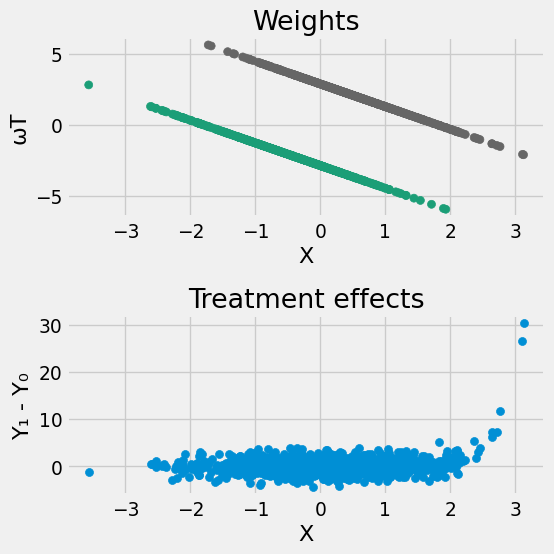

In [5]:
import matplotlib.cm as cm
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

# Create a scatter plot for the first panel (left)
axes[0].scatter(X[:,1], w, c=T, cmap=cm.Dark2)
axes[0].set_xlabel("X")
axes[0].set_ylabel("ωT")
axes[0].set_title("Weights")

axes[1].scatter(X[:,1], y1-y0, label="TE")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y₁ - Y₀")
axes[1].set_title("Treatment effects")


# Display the plot
plt.tight_layout()  # Ensure proper layout spacing
plt.show()

# Matching

## Matching

-   If not regression, then what? $$
    ATE = \int \Er[Y|T=1,X=x] - \Er[Y|T=0,X=x] dP(x)
    $$

## Plug-in estimator

-   Plug in estimator: $$
    \widehat{ATE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{E}[Y|T=1,X=X_i] - \hat{E}[Y|T=0,X=X_i] \right)
    $$ where $\hat{E}[Y|T,X]$ is some flexible estimator for
    $\Er[Y|T,X]$
    -   if $X$ is discrete, $\hat{E}$ can be conditional averages or
        equivalently, “saturated” regression
    -   if $X$ continuous, $\hat{E}$ can be some nonparametric
        regression estimator
    -   Original approaches to this problem used nearest neighbor
        matching to estimate $\hat{E}[Y|T,X]$
-   Downside:
    -   Difficult statistical properties — choice of tuning parameters,
        strong assumptions needed, failure of bootstrap for nearest
        neighbors Abadie and Imbens (2008)

## Propensity Score

-   Let $e(X) = P(T=1|X=X)$
-   Note: $$
    \begin{align*}
    \Er[Y|X,T=1] - \Er[Y|X,T=0] = & E\left[\frac{Y T}{e(X)}|X \right] - E\left[\frac{Y(1-T)}{1-e(X)}|X \right] \\
    = & E\left[ Y \frac{T - e(X)}{e(X)(1-e(X))} | X \right]
    \end{align*}
    $$

## Propensity Score

-   so $$
    ATE = \Er\left[ \frac{Y T}{e(X)} -  \frac{Y(1-T)}{1-e(X)}\right] = \Er\left[ Y \frac{T - e(X)}{e(X)(1-e(X))} \right]
    $$

## Inverse propensity weighting

-   Estimator $$
    \widehat{ATE}^{IPW} = \frac{1}{n} \sum_{i=1}^n \frac{Y_iT_i}{\hat{e}(X_i)} - \frac{Y_i(1-T_i)}{1-\hat{e}(X_i)}
    $$ where $\hat{e}(X)$ is some flexible estimator for $P(T=1|X)$

-   Downside:

    -   Difficult statistical properties — choice of tuning parameters,
        strong assumptions needed

## Doubly Robust Estimator

-   Estimator $$
    \begin{align*}
    \widehat{ATE}^{DR} = & \frac{1}{n} \sum_{i=1}^n \hat{E}[Y|T=1,X=X_i] - \hat{E}[Y|T=0,X=X_i] + \\
    & + \frac{1}{n} \sum_{i=1}^n  \frac{T_i(Y_i - \hat{E}[Y|T=1,X=X_i])}{\hat{e}(X_i)} - \\
    & - \frac{(1-T_i)(Y_i - \hat{E}[Y|T=0,X=X_i])} {1-\hat{e}(X_i)}
    \end{align*}
    $$

## Doubly Robust Estimator

-   Doubly robust in that:
    -   Consistent as long as either $\hat{e}(X) \inprob e(X)$ or
        $\hat{E}[Y|T,X] \inprob \Er[Y|T,X]$
    -   Insensitive to small changes in $\hat{e}(X)$ or $\hat{E}[Y|T,X]$
-   Allows: nicer statistical properties
    -   Weaker assumptions needed
    -   Asymptotic distribution is the same as if $e(X)$ and
        $\Er[Y|T,X]$ were known

## Software

-   Advice: use the doubly robust estimator with nonparametric estimates
    for $\hat{E}[Y|T,X]$ and $\hat{e}(X)$
-   Recommended package:
    -   [econml](https://econml.azurewebsites.net/spec/estimation/dr.html)
        has the correct estimator and examples of using it with
        nonparametric estimates
        -   focuses on conditional instead of unconditional average
            treatment effects, but can be used for both

## Software

-   Other packages:
    -   [causalinference](https://github.com/laurencium/Causalinference)
        has a double robust estimator, but it estimates $\hat{E}[Y|T,X]$
        via linear regression and $\hat{e}(X)$ via logit (maybe probit,
        not sure)
        -   can make nonparametric by adding e.g. powers of $x$ to $X$,
            but need to manage manually
    -   [zEpid](https://zepid.readthedocs.io/en/stable/Reference/generated/zepid.causal.doublyrobust.AIPW.AIPTW.html#zepid.causal.doublyrobust.AIPW.AIPTW)
        is similiar to causalinference, but has a formula interface, so
        slightly easier to make model more flexible

## Example: simulation

-   Infeasible estimator: average of $Y_1 - Y_0$

In [6]:
se = np.sqrt(np.var(y1-y0)/len(y1))
ate = np.mean(y1-y0)
print(ate-1.96*se, ate, ate+1.96*se)

0.10010844404085255 0.22383059765273303 0.3475527512646135

## Example: simulation

In [7]:
from econml.dr import DRLearner, LinearDRLearner, SparseLinearDRLearner
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LassoCV, LogisticRegressionCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures#

est = LinearDRLearner(featurizer=PolynomialFeatures(degree=20, include_bias=False),
                model_regression=LassoCV(),
                model_propensity=LogisticRegressionCV(),
                #model_final=StatsModelsLinearRegression(),
                cv=10)
est.fit(y, T, X=None, W=X)

/home/paul/526/mine/site/env/lib/python3.11/site-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/paul/526/mine/site/env/lib/python3.11/site-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/paul/526/mine/site/env/lib/python3.11/site-packages/shap/utils/_clustering.py:62

In [8]:
point = est.const_marginal_effect(None)
lb, ub = est.const_marginal_effect_interval(None, alpha=0.05)
print(lb,point,ub)

[[-0.03922896]] [[0.12089912]] [[0.28102719]]

# Growth Mindset

## National Study of Learning Mindsets

-   Original study by Yeager et al. (2019)
-   Synthetic data created by Athey and Wager (2019), downloaded from
    Facure (2022)

## Data

In [9]:
import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from causalinference import CausalModel
style.use("fivethirtyeight")
pd.set_option("display.max_columns", 20)
datadir="./data"

In [10]:
data = pd.read_csv(datadir+"/learning_mindset.csv")
data.sample(5, random_state=431)

## Evidence of Confounding

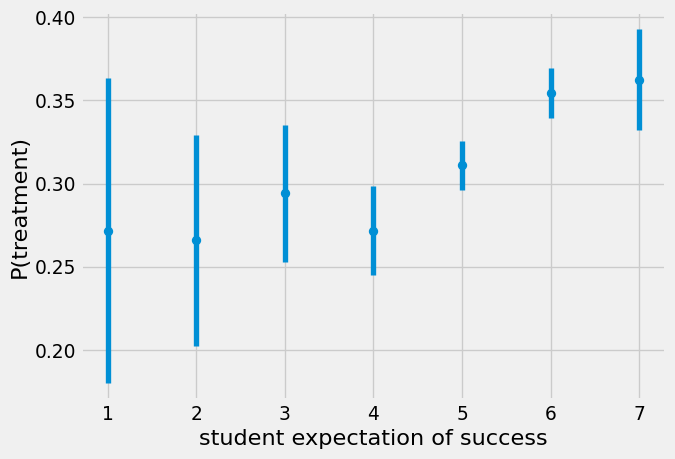

In [11]:
def std_error(x):
    return np.std(x, ddof=1) / np.sqrt(len(x))

grouped = data.groupby('success_expect')['intervention'].agg(['mean', std_error])
grouped = grouped.reset_index()

fig, ax = plt.subplots()
plt.errorbar(grouped['success_expect'],grouped['mean'],yerr=1.96*grouped['std_error'],fmt="o")
ax.set_xlabel('student expectation of success')
ax.set_ylabel('P(treatment)')
plt.show()

## Unadjusted estimate of ATE

In [12]:
print(smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1])

                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1538      0.012    -13.201      0.000      -0.177      -0.131
intervention     0.4723      0.020     23.133      0.000       0.432       0.512

In [13]:
print(smf.ols("achievement_score ~ intervention", data=data).fit(
    cov_type="cluster", cov_kwds={'groups': data['schoolid']}).summary().tables[1])

                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1538      0.036     -4.275      0.000      -0.224      -0.083
intervention     0.4723      0.025     19.184      0.000       0.424       0.521

## Unadjusted estimate of ATE

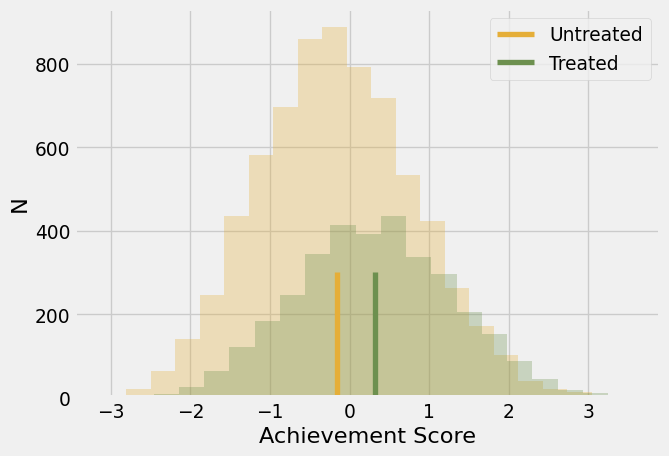

In [14]:
fig,ax=plt.subplots()
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
ax.set_xlabel("Achievement Score")
ax.set_ylabel("N")
plt.legend()
plt.show();

## Regression estimate of ATE

In [15]:
ols = smf.ols("achievement_score ~ intervention + success_expect + ethnicity + gender + frst_in_family + school_urbanicity + school_mindset + school_achievement + school_ethnic_minority + school_poverty + school_size",data=data).fit()
print(ols.summary().tables[1])

                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.7786      0.056    -31.880      0.000      -1.888      -1.669
intervention               0.3964      0.018     22.192      0.000       0.361       0.431
success_expect             0.3746      0.008     49.514      0.000       0.360       0.389
ethnicity                  0.0043      0.002      2.049      0.040       0.000       0.008
gender                    -0.2684      0.017    -16.060      0.000      -0.301      -0.236
frst_in_family            -0.1310      0.018     -7.248      0.000      -0.166      -0.096
school_urbanicity          0.0573      0.007      8.240      0.000       0.044       0.071
school_mindset            -0.1484      0.011    -13.083      0.000      -0.171      -0.126
school_achievement        -0.0253      0.013     -1.902      0.057      -0.051       0.001

## Regression estimate of ATE: weights

In [16]:
lpm = smf.ols("intervention ~ success_expect + ethnicity + gender + frst_in_family + school_urbanicity + school_mindset + school_achievement + school_ethnic_minority + school_poverty + school_size",data=data).fit(cov_type="cluster", cov_kwds={'groups': data['schoolid']})
w = lpm.resid / np.var(lpm.resid)
print(np.mean(data.achievement_score*w))

0.39640236033389553

## Regression estimate of ATE: weights

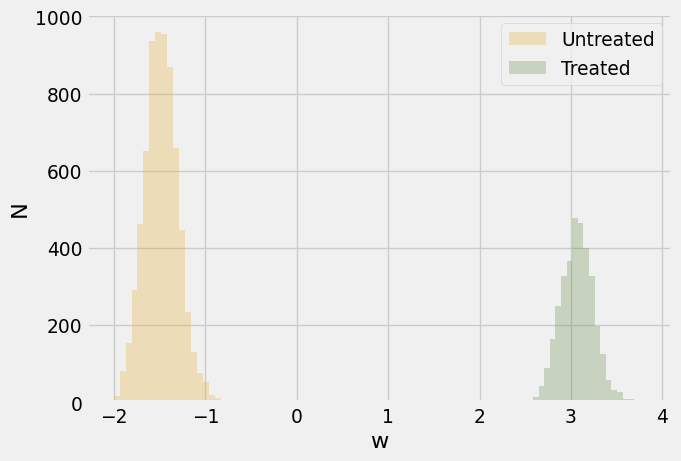

In [17]:
fig,ax=plt.subplots()
plt.hist(w[data.intervention==0], bins=20, alpha=0.3, color="C2", label="Untreated")
plt.hist(w[data.intervention==1], bins=20, alpha=0.3, color="C3", label="Treated")
ax.set_xlabel("w")
ax.set_ylabel("N")
plt.legend()
plt.show();

## Propensity Score Matching

In [18]:
categ = ["ethnicity", "gender", "school_urbanicity","success_expect"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

(10391, 38)

## Propensity Score Matching

In [19]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
import sklearn

def propensitymatching(T,Y,X,psmodel=LogisticRegressionCV(),neighbormodel=KNeighborsRegressor(n_neighbors=1,algorithm='auto',weights='uniform')):
    pfit = psmodel.fit(X,T)
    ps = pfit.predict_proba(X)[:,1]
    ey1 = neighbormodel.fit(ps[T==1].reshape(-1,1),Y[T==1])
    ey0 = sklearn.base.clone(neighbormodel).fit(ps[T==0].reshape(-1,1),Y[T==0])
    tex = ey1.predict(ps.reshape(-1,1)) - ey0.predict(ps.reshape(-1,1))
    ate = np.mean(tex)
    return(ate, tex,ps)

ate,tex,ps=propensitymatching(data_with_categ[T],data_with_categ[Y],data_with_categ[X])
print(ate)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

0.3423570909254285

## Propensity Score Matching

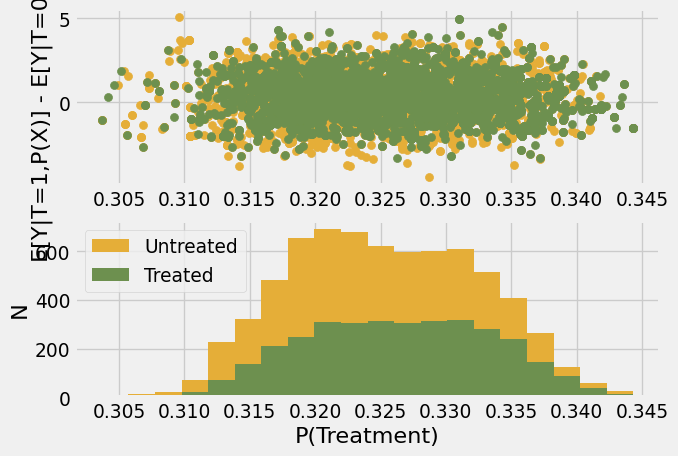

In [20]:
fig, ax = plt.subplots(2,1)
treat = data.intervention
ax[0].scatter(ps[treat==0],tex[treat==0],color="C2")
ax[0].scatter(ps[treat==1],tex[treat==1],color="C3")
ax[1].hist(ps[treat==0],bins=20,color="C2",label="Untreated")
ax[1].hist(ps[treat==1],bins=20,color="C3",label="Treated")
ax[1].set_xlabel("P(Treatment)")
ax[1].set_ylabel("N")
ax[0].set_ylabel("E[Y|T=1,P(X)] - E[Y|T=0,P(X)]")
plt.legend()
plt.show()

## Inverse Propensity Weighting

In [21]:
def ipw(T,Y,X,psmodel=LogisticRegressionCV()):
    pfit = psmodel.fit(X,T)
    ps = pfit.predict_proba(X)[:,1]
    ate=np.mean(Y*(T - ps)/(ps*(1-ps)))
    return(ate,ps)

ate,ps = ipw(data_with_categ[T],data_with_categ[Y],data_with_categ[X])
print(ate)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

0.46498505452715805

## Doubly Robust

In [22]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LassoCV, LogisticRegressionCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures

def robustate(T,Y,X,psmodel=LogisticRegressionCV(),ymodel=LassoCV(), cluster=None):
    pfit = psmodel.fit(X,T)
    ps = pfit.predict_proba(X)[:,1]
    ey1fit = ymodel.fit(X[T==1],Y[T==1])
    ey0fit = sklearn.base.clone(ymodel).fit(X[T==0],Y[T==0])
    ey1 = ey1fit.predict(X)
    ey0 = ey0fit.predict(X)
    ate_terms = ey1 - ey0 + T*(Y- ey1)/ps - (1-T)*(Y-ey0)/(1-ps)
    ate = np.mean(ate_terms)
    # check if cluster is None
    if cluster is None :
        ate_se = np.sqrt(np.var(ate_terms)/len(ate_terms))
    else :
        creg=smf.ols("y ~ 1", pd.DataFrame({"y" : ate_terms})).fit(cov_type="cluster", cov_kwds={'groups': cluster})
        ate_se = np.sqrt(creg.cov_params().iloc[0,0])

    return(ate, ate_se, ps, ey1,ey0)

ate,se,ps,ey1,ey0 = robustate(data_with_categ[T],data_with_categ[Y],data_with_categ[X],cluster=data_with_categ['schoolid'])
print(ate-1.96*se, ate, ate+1.96*se)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

0.33214226035254746 0.3836157943394324 0.4350893283263173

[1]

## Doubly Robust

-   better to use the `econml` package

[1] We have glossed over some details needed for doubly robust
estimation to have nice statistical properties. Those details matter and
are not implemented correctly above. It is better to use the econml
instead.

In [23]:
from econml.dr import DRLearner, LinearDRLearner, SparseLinearDRLearner

est = LinearDRLearner(#featurizer=PolynomialFeatures(degree=2, include_bias=False),
                model_regression=LassoCV(),
                model_propensity=LogisticRegressionCV(),
                cv=5)

est.fit(data_with_categ[Y], data_with_categ[T], X=None, W=data_with_categ[X])
point = est.const_marginal_effect(None)
lb, ub = est.const_marginal_effect_interval(None, alpha=0.05)
print(lb,point,ub)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

[[0.35515763]] [[0.38856831]] [[0.42197899]]

## Sources and Further Reading

-   Useful additional reading is [chapters
    10-12](https://matheusfacure.github.io/python-causality-handbook/10-Matching.html)
    of Facure (2022) and [chapter
    14](https://theeffectbook.net/ch-Matching.html) of Huntington-Klein
    (2021).[1]

-   The representation of the estimate from a linear model as a weighted
    average is based on Borusyak and Jaravel (2018)

-   The growth mindset example is take from Facure (2022)

## References

Abadie, Alberto, and Guido W. Imbens. 2008. “On the Failure of the
Bootstrap for Matching Estimators.” *Econometrica* 76 (6): 1537–57.
https://doi.org/<https://doi.org/10.3982/ECTA6474>.

Athey, Susan, and Stefan Wager. 2019. “Estimating Treatment Effects with
Causal Forests: An Application.”

Borusyak, Kirill, and Xavier Jaravel. 2018. “Revisiting Event Study
Designs.”
<https://scholar.harvard.edu/files/borusyak/files/borusyak_jaravel_event_studies.pdf>.

Facure, Matheus. 2022. *Causal Inference for the Brave and True*.
<https://matheusfacure.github.io/python-causality-handbook/landing-page.html>.

Huntington-Klein, Nick. 2021. *The Effect: An Introduction to Research
Design and Causality*. CRC Press. <https://theeffectbook.net/>.

Yeager, David S., Paul Hanselman, Gregory M. Walton, Jared S. Murray,
Robert Crosnoe, Chandra Muller, Elizabeth Tipton, et al. 2019. “A
National Experiment Reveals Where a Growth Mindset Improves
Achievement.” *Nature* 573 (7774): 364–69.
<https://doi.org/10.1038/s41586-019-1466-y>.

[1] These slides do not mention the importance of overlap/balance, but
hopefully I emphasized it during lecture. Overlap is very important in
practice. The reading, especially Huntington-Klein (2021), cover it
pretty well.